## Import Libraries
- numpy
- kmodes (download kmodes library)
- pandas
- ast
- matplotlib
- seaborn

In [436]:
!pip install kmodes --quiet
!pip install gower --quiet
!pip install optuna --quiet
!pip install gower validclust --quiet


In [ ]:
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import gower
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn


In [438]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


## Load Data
Dataset of all NDRMMC tropical cyclone records from 2021-2025


https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv

In [439]:
df = pd.read_csv('https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv')
df.head()

,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,Missing,Totally,Partially,Total,Quantity,Cost,Type,Category
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,22690.0,13172269.32,"['BLANKET', 'BUTANE GAS STOVE', 'CANISTER', 'F...","['FAMILY FOOD PACK', 'HYGIENE KIT', 'KITCHEN K..."
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,4800.0,2948690,"['FAMILY FOOD PACK', 'FINANCIAL', 'HYGIENE KIT...","['FAMILY FOOD PACK', 'FINANCIAL / SOCIAL ASSIS..."
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,228.0,46740,['FAMILY FOOD PACK'],['FAMILY FOOD PACK']
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,NaN,NaN,NaN,5.0,0.0,5.0,NaN,NaN,NaN,NaN
4,AGATON,2022,6,ILOILO,ALIMODIAN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228 entries, 0 to 9227
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Typhoon Name       9228 non-null   object 
 1   Year               9228 non-null   int64  
 2   Region             9228 non-null   object 
 3   Province           9228 non-null   object 
 4   City/Municipality  9206 non-null   object 
 5   Families           8704 non-null   float64
 6   Person             8704 non-null   float64
 7   Brgy               8704 non-null   float64
 8   Dead               507 non-null    float64
 9   Injured/Ill        507 non-null    float64
 10  Missing            507 non-null    float64
 11  Totally            3815 non-null   float64
 12  Partially          3815 non-null   float64
 13  Total              3815 non-null   float64
 14  Quantity           3638 non-null   float64
 15  Cost               3769 non-null   object 
 16  Type               3523 

## Data Preprocessing

### 1.1 Standardization of data

Fix column names for consistency and readability & convert all of them to lowercase snakecase




In [441]:
df.rename(columns={'Category': 'Category_Aid'}, inplace=True)


In [442]:
df.columns = df.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

print("Columns now:", list(df.columns))

Columns now: ['typhoon_name', 'year', 'region', 'province', 'city_municipality', 'families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'totally', 'partially', 'total', 'quantity', 'cost', 'type', 'category_aid']


In [443]:
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

Remove unnecessary columns
- type (baseline simplication basis of category)
- quantity (inconsistent values, same depth across all aids, not realiable)

In [444]:
df.drop(['type', 'quantity'], axis=1, inplace=True)

### 1.2 Handling Categorical & Impact Missing Values
Print the NaN/null values



In [445]:
df.isnull().sum()

,0
typhoon_name,0
year,0
region,0
province,0
city_municipality,22
families,524
person,524
brgy,524
dead,8721
injured_ill,8721


category -> replace NaN with ```['NOT SPECIFIED]```'

In [446]:
df['category_aid'] = df['category_aid'].fillna("['NOT SPECIFIED']")

city_municipality -> replace NaN with ```'UNKNOWN'```

In [447]:
df['city_municipality'] = df['city_municipality'].fillna('UNKNOWN')

impact-related columns ```(families, brgy, dead, injured_ill, missing, totally, partially, total)``` replace NaN with 0

In [448]:
zero_fill_cols = [
    'families', 'person', 'brgy',
    'dead', 'injured_ill', 'missing',
    'totally', 'partially', 'total'
]

df[zero_fill_cols] = df[zero_fill_cols].fillna(0)

In [449]:
# Count rows where 'person' is 0
zero_person_count = df[df['person'] == 0].shape[0]
print(f"Number of rows with 0 persons: {zero_person_count}")

# Remove rows where 'person' is 0
df = df[df['person'] > 0].copy()
print(f"Remaining rows after removal: {df.shape[0]}")

Number of rows with 0 persons: 980
Remaining rows after removal: 8248


In [450]:
for col in ['region', 'province', 'city_municipality']:
    df[col] = df[col].str.upper()

### 1.3 Verification Tagging
Events are tagged as either verified or unverified by the means of data

parse category column string to list

In [451]:
def parse_category(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x]
    except:
        return  ['NOT SPECIFIED']

df['category_aid'] = df['category_aid'].apply(parse_category)


**Verified events:** contain significant values in key columns (e.g. families, person, cost)

**Unverified events:** lacks significant values and having a unspecified categories (categories that equals to ```['NOT SPECIFIED']```, ```['NO BREAKDOWN']```, ```['FOR VERIFCATION']```)

In [452]:
category_counts = df['category_aid'].explode().value_counts()
print(category_counts)

category_aid
NOT SPECIFIED                            5194
FAMILY FOOD PACK                         2284
FINANCIAL / SOCIAL ASSISTANCE             670
OTHERS                                    602
HYGIENE KIT                               354
SLEEPING KIT                              288
NO BREAKDOWN                              169
KITCHEN KIT                               166
SHELTER KIT                               109
READY TO EAT FOOD                         105
FOR VERIFICATION                          103
CLOTHING KIT                               73
LOGISTICAL SUPPORT                         22
MEDICAL                                     6
READY TO EAT FOOD, LOGISTICAL SUPPORT       1
LIVELIHOOD                                  1
READY TO EAT FOOD, CLOTHING KIT             1
Name: count, dtype: int64


In [453]:
unverified_mask = df['category_aid'].apply(
    lambda x: any(item in ['NOT SPECIFIED', 'NO BREAKDOWN', 'FOR VERIFICATION'] for item in x)
)

In [454]:
unverified_mask.value_counts()

,count
category_aid,
True,5466
False,2782


### 1.4 Handling Missing Data using Unverified Masked

cost -> replace NaN with median cost (from tagged verified records only)

In [455]:
valid_cost_mask = ~unverified_mask & df['cost'].notna()
cost_median = df[valid_cost_mask]['cost'].median()

df.loc[~unverified_mask & df['cost'].isna(), 'cost'] = cost_median
df['cost'] = df['cost'].fillna(0) # final fallback

### 1.5 Simplication Mapping and Encoding of Category

*   Simplify and consolidate raw categories into fewer, more meaningful groups
*   Apply one-hot encoding to thematic varaibles for downstream analysis



In [456]:
def clean_and_split(lst):
    cleaned = []
    for item in lst:
        item = str(item).strip()
        # Handle combined: "READY TO EAT FOOD, CLOTHING KIT"
        if ',' in item and any(k in item for k in ['KIT', 'FOOD']):
            parts = [p.strip() for p in item.split(',') if p.strip()]
            cleaned.extend(parts)
        else:
            cleaned.append(item)
    return [c for c in cleaned if c not in ['', 'UNVERIFIED']]

# apply
df['category_aid'] = df['category_aid'].apply(clean_and_split)

In [457]:
# Mapping for normalization
mapping = {
    'NOT SPECIFIED': 'UNVERIFIED',
    'NO BREAKDOWN': 'UNVERIFIED',
    'FOR VERIFICATION': 'UNVERIFIED',
    'READY TO EAT FOOD': 'READY-TO-EAT MEALS',
    'CLOTHING KIT': 'CLOTHING',
    'LOGISTICAL SUPPORT': 'LOGISTICS',
    'MEDICAL': 'MEDICAL ASSISTANCE',
    'OTHERS': 'OTHER / UNSPECIFIED'
}

def standardize(item):
    return mapping.get(item.upper(), item.upper())  # normalize via mapping

def get_themes(items):
    themes = set()
    for item in items:
        item = standardize(item)
        if any(k in item for k in ['FAMILY FOOD PACK', 'READY-TO-EAT MEALS']):
            themes.add('Food')
        elif 'FINANCIAL' in item or 'SOCIAL ASSISTANCE' in item:
            themes.add('Cash')
        elif 'HYGIENE KIT' in item or 'MEDICAL ASSISTANCE' in item:
            themes.add('Hygiene & Health')
        elif 'SLEEPING KIT' in item or 'KITCHEN KIT' in item:
            themes.add('Sleeping Essentials')
        elif 'SHELTER KIT' in item or 'CLOTHING' in item or 'TARP' in item:
            themes.add('Shelter Support')
        elif 'LOGISTICS' in item:
            themes.add('Logistics')
        elif 'OTHER / UNSPECIFIED' in item:
            themes.add('Other')
        else:
            themes.add('Unverified')
    return list(themes)

# apply
df['aid_themes'] = df['category_aid'].apply(get_themes)

In [458]:
for theme in ['Food', 'Cash', 'Hygiene & Health', 'Sleeping Essentials', 'Shelter Support']:
    col_name = f'has_{theme.lower().replace(" & ", "_").replace(" ", "_")}'
    df[col_name] = df['aid_themes'].apply(lambda x: 1 if theme in x else 0)

In [459]:
# Show distribution of themes
all_themes = [t for themes in df['aid_themes'] for t in themes]
theme_counts = pd.Series(all_themes).value_counts()
print(theme_counts)

Unverified             5467
Food                   2323
Cash                    670
Other                   602
Hygiene & Health        356
Sleeping Essentials     327
Shelter Support         169
Logistics                23
Name: count, dtype: int64


In [460]:
df.drop(['aid_themes', 'category_aid'], axis=1, inplace=True)

In [461]:
df

,typhoon_name,year,region,province,city_municipality,families,person,brgy,dead,injured_ill,missing,totally,partially,total,cost,has_food,has_cash,has_hygiene_health,has_sleeping_essentials,has_shelter_support
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,13172269.32,1,0,1,1,0
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,2948690.00,1,1,1,1,0
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,46740.00,1,0,0,0,0
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.00,0,0,0,0,0
5,AGATON,2022,8,BILIRAN,ALMERIA,125.0,488.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9223,FABIAN,2021,NCR,NCR,TAGUIG CITY,264.0,987.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0
9224,KRISTINE-LEON,2024,NCR,NCR,TAGUIG CITY,1519.0,6055.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,988350.00,0,0,0,0,0
9225,FABIAN,2021,NCR,NCR,VALENZUELA,387.0,1420.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0
9226,GORING-HANNA-INENG,2023,NCR,NCR,VALENZUELA,3.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0


## Feature Engineering

### 2.1 Transformation from Event-Based to Province-Based Data

*   Create a composite ID = ```(province, region)```

Aggregate data by composite ID:
* Sum ```(families, person, dead, injured_ill, missing, totally, partially, cost)```
* Mean ```(has_food, has_cash, has_hygiene_health, has_sleeping_essentials, has_shelter_support)```
* Count Number of typhoon events using nunique
* First and last year for recurrence rate, year min max







In [462]:
# --- Step 1. Clean and prepare typhoon names ---
df['typhoon_name_clean'] = df['typhoon_name'].str.strip()

# Create exploded version for individual typhoons
df['typhoon_list'] = df['typhoon_name_clean'].str.split('-')
df_exploded = df.explode('typhoon_list')
df_exploded['typhoon_list'] = df_exploded['typhoon_list'].str.strip()

# --- Step 2. Aggregation dictionary (without typhoon_name nunique here) ---
agg_dict = {
    # Impact & Damage (sum)
    'families': 'sum',
    'person': 'sum',
    'dead': 'sum',
    'injured_ill': 'sum',
    'missing': 'sum',
    'totally': 'sum',
    'partially': 'sum',
    'cost': 'sum',

    # Aid flags (mean across events)
    'has_food': 'sum',
    'has_cash': 'sum',
    'has_hygiene_health': 'sum',
    'has_sleeping_essentials': 'sum',
    'has_shelter_support': 'sum',

    # First and last year for recurrence rate
    'year': ['min', 'max'],
}

# --- Step 3. Province-level aggregation for impact & aid ---
province_df = df.groupby(['province', 'region']).agg(agg_dict).reset_index()

# Flatten column names after multi-level aggregation
province_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in province_df.columns]
province_df = province_df.rename(columns={
    'province': 'province_',
    'region': 'region_',
    'year_min': 'first_year',
    'year_max': 'last_year'
})

# --- Step 4. Province-level typhoon counts ---

# (a) Count unique report names (original merged names)
province_reports = (
    df.groupby(['province', 'region'])
      .agg({'typhoon_name_clean': 'nunique'})
      .reset_index()
      .rename(columns={'typhoon_name_clean': 'num_reports'})
)

# (b) Count unique individual typhoons (after split/explode)
province_typhoons = (
    df_exploded.groupby(['province', 'region'])
               .agg({'typhoon_list': 'nunique'})
               .reset_index()
               .rename(columns={'typhoon_list': 'num_typhoons'})
)

# --- Step 5. Merge into final province_df ---
province_df = (
    province_df
    .merge(province_reports, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .merge(province_typhoons, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .drop(columns=['province_x', 'region_x', 'province_y', 'region_y'])
)


In [463]:
province_df

,province_,region_,families_sum,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,first_year,last_year,num_reports,num_typhoons
0,ABRA,CAR,191000.0,665436.0,2.0,115.0,0.0,58.0,888.0,29463089.14,61,46,8,4,4,2021,2025,17,29
1,AGUSAN DEL NORTE,13,380.0,1651.0,0.0,0.0,0.0,4.0,6.0,280324.00,0,0,0,0,0,2024,2024,1,2
2,AGUSAN DEL NORTE,CARAGA,44665.0,187974.0,0.0,0.0,0.0,2872.0,9370.0,20049094.82,1,0,0,0,0,2021,2025,6,7
3,AGUSAN DEL SUR,CARAGA,55722.0,221391.0,0.0,0.0,0.0,167.0,707.0,6707484.86,3,0,0,0,0,2021,2024,4,5
4,AKLAN,6,170922.0,637351.0,8.0,2.0,1.0,273.0,9530.0,66326300.00,51,35,1,3,0,2021,2025,13,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,ZAMBALES,3,53287.0,176692.0,2.0,4.0,0.0,165.0,302.0,16125246.30,19,0,1,0,1,2020,2025,18,29
94,ZAMBOANGA CITY,9,21043.0,96666.0,7.0,0.0,0.0,315.0,361.0,13865559.72,2,1,0,1,0,2021,2025,6,12
95,ZAMBOANGA DEL NORTE,9,50371.0,233216.0,0.0,1.0,0.0,118.0,185.0,4355621.00,7,1,0,1,0,2021,2025,6,13
96,ZAMBOANGA DEL SUR,9,4694.0,19519.0,0.0,0.0,0.0,70.0,222.0,397129.40,2,0,2,1,0,2021,2025,6,13


### 2.2 Derived Features

*   new column for ```recurrence_rate``` = num of typhoons / (last year - first year + 1)
*   new column for ```cost_per_family``` = cost_sum / families_sum[link text](https://)



In [464]:
province_df['recurrence_rate'] = province_df['num_typhoons'] / (
    province_df['last_year'] - province_df['first_year'] + 1
)

In [465]:
province_df['cost_per_family'] = province_df.apply(
    lambda row: row['cost_sum'] / row['families_sum'] if row['families_sum'] > 0 else np.nan,
    axis=1
)

In [466]:
province_df.isnull().sum()

,0
province_,0
region_,0
families_sum,0
person_sum,0
dead_sum,0
injured_ill_sum,0
missing_sum,0
totally_sum,0
partially_sum,0
cost_sum,0


## Feature Selection
Building correlation matrix and removing
```families_sum, first_year, last_year, total```

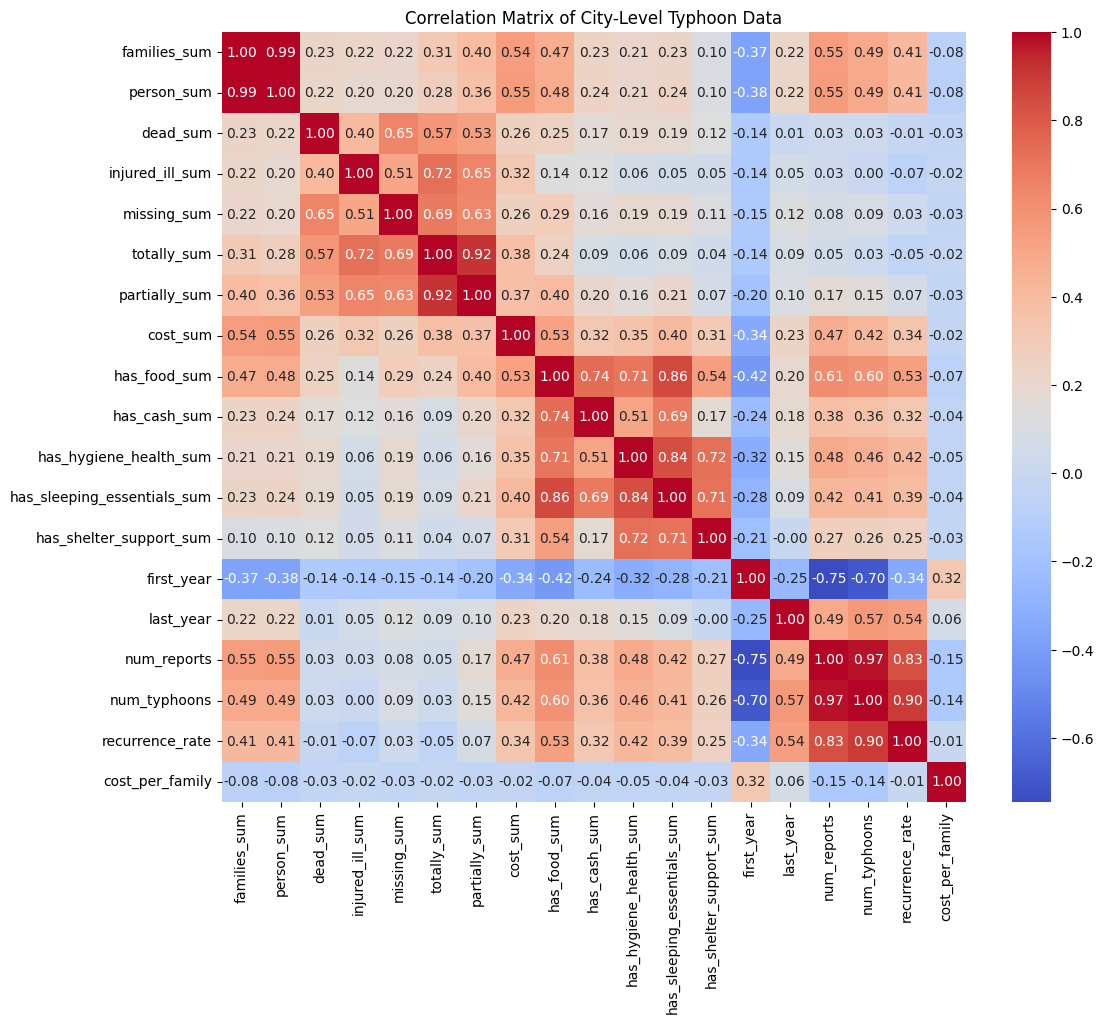

In [467]:
correlation_matrix = province_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of City-Level Typhoon Data')
plt.show()

In [468]:
province_df.drop(['families_sum', 'first_year', 'last_year', 'num_reports'], axis=1, inplace=True)


#### Changing the index to province + region

In [469]:
# Create a unique province-region ID
province_df['province_region'] = province_df['province_'] + ' (' + province_df['region_'] + ')'

# Set it as index (optional but clean)
province_df.set_index('province_region', inplace=True)

# Now drop the original 'province_' column
province_df.drop(columns=['province_'], inplace=True)

In [470]:
province_df.columns

Index(['region_', 'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate',
       'cost_per_family'],
      dtype='object')

In [471]:
province_df.head()

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,665436.0,2.0,115.0,0.0,58.0,888.0,29463089.14,61,46,8,4,4,29,5.80,154.257011
AGUSAN DEL NORTE (13),13,1651.0,0.0,0.0,0.0,4.0,6.0,280324.00,0,0,0,0,0,2,2.00,737.694737
AGUSAN DEL NORTE (CARAGA),CARAGA,187974.0,0.0,0.0,0.0,2872.0,9370.0,20049094.82,1,0,0,0,0,7,1.40,448.877081
AGUSAN DEL SUR (CARAGA),CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6707484.86,3,0,0,0,0,5,1.25,120.374087
AKLAN (6),6,637351.0,8.0,2.0,1.0,273.0,9530.0,66326300.00,51,35,1,3,0,22,4.40,388.050105


In [472]:
province_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, ABRA (CAR) to ZAMBOANGA SIBUGAY (9)
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_                      98 non-null     object 
 1   person_sum                   98 non-null     float64
 2   dead_sum                     98 non-null     float64
 3   injured_ill_sum              98 non-null     float64
 4   missing_sum                  98 non-null     float64
 5   totally_sum                  98 non-null     float64
 6   partially_sum                98 non-null     float64
 7   cost_sum                     98 non-null     float64
 8   has_food_sum                 98 non-null     int64  
 9   has_cash_sum                 98 non-null     int64  
 10  has_hygiene_health_sum       98 non-null     int64  
 11  has_sleeping_essentials_sum  98 non-null     int64  
 12  has_shelter_support_sum      98 non-null     int64  
 13 

In [473]:
province_df.shape

(98, 16)

In [474]:
province_df.to_csv('province_typhoon_data.csv', index=False)

In [475]:
province_df.describe()

,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
count,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,7.229812e+05,8.153061,22.948980,0.948980,5622.204082,24880.846939,5.676238e+07,23.704082,6.836735,3.632653,3.336735,1.724490,15.724490,3.149830,885.691952
std,1.064488e+06,21.376040,63.004561,2.602031,17743.807573,70556.086701,8.606198e+07,34.018251,15.867164,6.558834,6.659531,4.178444,8.645099,1.196715,5147.192178
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.750000,0.000000
25%,3.340825e+04,0.000000,0.000000,0.000000,25.000000,129.000000,1.361105e+06,1.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2.200000,129.866663
50%,3.209590e+05,1.500000,1.000000,0.000000,165.000000,1136.000000,2.083714e+07,11.000000,1.000000,1.000000,1.000000,0.000000,15.500000,3.083333,284.551413
75%,9.297928e+05,6.000000,8.000000,0.000000,2141.750000,17764.250000,6.850916e+07,34.750000,5.000000,5.000000,4.000000,1.000000,23.750000,4.166667,484.114243
max,6.318463e+06,155.000000,374.000000,15.000000,127560.000000,580822.000000,4.775400e+08,205.000000,104.000000,46.000000,35.000000,28.000000,31.000000,5.800000,51138.333333


## EDA

## Model Training

#### Applying Standard Scaling

In [476]:
from sklearn.preprocessing import StandardScaler

final_df = province_df.copy()
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
print(f"numerical_columns: {numerical_cols}")

scaler = StandardScaler()
province_df[numerical_cols] = scaler.fit_transform(province_df[numerical_cols])

print("DataFrame after Standard Scaling:")
display(province_df.head())

numerical_columns: ['person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum', 'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate', 'cost_per_family']
DataFrame after Standard Scaling:


,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,-0.054337,-0.289328,1.468533,-0.366582,-0.315198,-0.341802,-0.318836,1.101987,2.480886,0.669296,0.100108,0.547383,1.543506,2.225923,-0.142834
AGUSAN DEL NORTE (13),13,-0.681115,-0.383372,-0.366116,-0.366582,-0.318257,-0.354367,-0.659669,-0.700387,-0.433088,-0.556704,-0.503623,-0.414833,-1.595708,-0.965762,-0.028901
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.505180,-0.383372,-0.366116,-0.366582,-0.155792,-0.220967,-0.428785,-0.670840,-0.433088,-0.556704,-0.503623,-0.414833,-1.014372,-1.469712,-0.085301
AGUSAN DEL SUR (CARAGA),CARAGA,-0.473626,-0.383372,-0.366116,-0.366582,-0.309023,-0.344380,-0.584605,-0.611746,-0.433088,-0.556704,-0.503623,-0.414833,-1.246906,-1.595699,-0.149451
AKLAN (6),6,-0.080856,-0.007197,-0.334209,0.019709,-0.303019,-0.218688,0.111700,0.806516,1.784066,-0.403454,-0.050824,-0.414833,0.729636,1.050039,-0.097179


### Labeling Categorical and Numerical Data Columns

In [477]:
province_df.columns = province_df.columns.str.strip()
province_df['region_'] = province_df['region_'].astype(str)

categorical_columns = ['region_']
categorical_indices = [province_df.columns.get_loc(col) for col in categorical_columns]

### Silhoutte Score

In [478]:
# Prepare data for Gower (exclude nothing yet — we'll drop 'cluster' later if present)
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()

print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

k_range = range(2, 12)
silhouette_scores = []
costs = []

print("\nRunning K-Prototypes for k = 2 to 10...")
for k in k_range:
    print(f"  k = {k} ...", end="")

    # Run K-Prototypes
    kproto = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=10,
        verbose=0,
        random_state=42
    )

    X = province_df.drop(columns=['cluster'], errors='ignore').values.astype(object)
    clusters = kproto.fit_predict(X, categorical=categorical_indices)

    # Compute silhouette score using precomputed Gower distance
    sil_score = silhouette_score(gower_dist, clusters, metric='precomputed')

    # Store results
    silhouette_scores.append(sil_score)
    costs.append(kproto.cost_)

    print(f" Silhouette = {sil_score:.4f}, Cost = {kproto.cost_:.2f}")


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!

Running K-Prototypes for k = 2 to 10...
  k = 2 ... Silhouette = 0.3791, Cost = 1156.07
  k = 3 ... Silhouette = 0.3420, Cost = 976.41
  k = 4 ... Silhouette = 0.2435, Cost = 798.52
  k = 5 ... Silhouette = 0.2178, Cost = 702.31
  k = 6 ... Silhouette = 0.1991, Cost = 633.23
  k = 7 ... Silhouette = 0.2058, Cost = 562.60
  k = 8 ... Silhouette = 0.1812, Cost = 525.49
  k = 9 ... Silhouette = 0.1992, Cost = 437.34
  k = 10 ... Silhouette = 0.2050, Cost = 409.42
  k = 11 ... Silhouette = 0.1815, Cost = 393.33


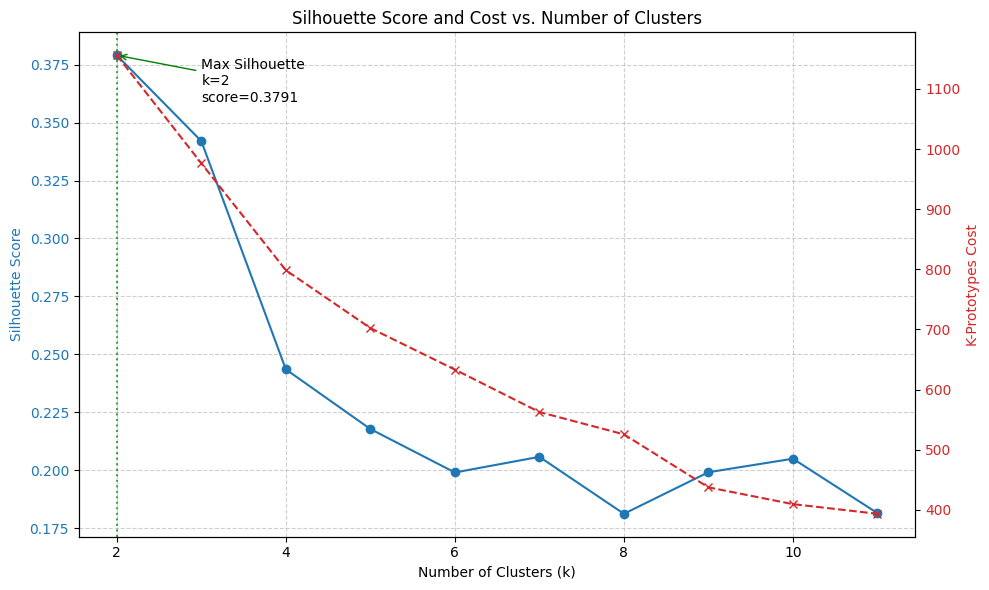


SUMMARY
k= 2 | Silhouette: 0.3791 | Cost:  1156.07
k= 3 | Silhouette: 0.3420 | Cost:   976.41
k= 4 | Silhouette: 0.2435 | Cost:   798.52
k= 5 | Silhouette: 0.2178 | Cost:   702.31
k= 6 | Silhouette: 0.1991 | Cost:   633.23
k= 7 | Silhouette: 0.2058 | Cost:   562.60
k= 8 | Silhouette: 0.1812 | Cost:   525.49
k= 9 | Silhouette: 0.1992 | Cost:   437.34
k=10 | Silhouette: 0.2050 | Cost:   409.42
k=11 | Silhouette: 0.1815 | Cost:   393.33

🎯 Recommended k (highest silhouette): 2


In [479]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(k_range, silhouette_scores, marker='o', color=color, label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Add second y-axis for cost (elbow method)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('K-Prototypes Cost', color=color)
ax2.plot(k_range, costs, marker='x', color=color, linestyle='--', label='Cost (Inertia)')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Silhouette Score and Cost vs. Number of Clusters')
fig.tight_layout()

# Optional: highlight best k by silhouette
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
ax1.axvline(x=best_k, color='green', linestyle=':', alpha=0.7, label=f'Best k = {best_k}')
ax1.annotate(f"Max Silhouette\nk={best_k}\nscore={best_score:.4f}",
             xy=(best_k, best_score),
             xytext=(best_k+1, best_score-0.02),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.show()

# ----------------------------
# 4. PRINT SUMMARY
# ----------------------------
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
for k, sil, cost in zip(k_range, silhouette_scores, costs):
    print(f"k={k:2d} | Silhouette: {sil:.4f} | Cost: {cost:8.2f}")

best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Recommended k (highest silhouette): {best_k}")

### Grid Search

In [480]:

param_grid = {
    'n_clusters': range(2, 11),  # Number of clusters to test
    'init': ['Huang', 'Cao'],   # Initialization methods
    'n_init': [5, 10]          # Number of initializations
}

# Create a list of parameter combinations
grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
results = []

print("Starting Grid Search for K-Prototypes...")
print("-" * 30)

# Prepare the data (Include data prep from the previous successful cell)
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

# Separate numerical and categorical data
X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

# Combine the data for K-Prototypes. K-Prototypes expects categorical features last.
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Get the indices of categorical columns in the combined matrix
# They will be after all numerical columns
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance matrix (if using precomputed metric for silhouette)
# Make sure 'gower_dist' is computed before the loop if metric='precomputed'
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy() # Re-create if needed
print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower) # Compute if needed
print("Gower distance computed!")


for params in grid:
    n_clusters = params['n_clusters']
    init_method = params['init']
    n_init = params['n_init']

    print(f"Testing params: k={n_clusters}, init='{init_method}', n_init={n_init}")

    try:
        # Initialize and train K-Prototypes model
        kp = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            verbose=0, # Set verbose to 0 for cleaner grid search output
            random_state=42
        )
        clusters = kp.fit_predict(X, categorical=categorical_indices_combined)
        score = silhouette_score(gower_dist, clusters, metric='precomputed')


        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': score,
            'cost': kp.cost_
        })

        print(f"  Silhouette Score: {score:.4f}, Cost: {kp.cost_:.2f}")

        # Check for best score
        if score > best_score:
            best_score = score
            best_params = params

    except Exception as e:
        print(f"  Error with params {params}: {e}")
        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': None,
            'cost': None,
            'error': str(e)
        })


print("-" * 30)
print("\nGrid Search Complete.")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Optional: Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='silhouette_score', ascending=False))

# Restore warnings
warnings.filterwarnings("default", category=DeprecationWarning)
warnings.filterwarnings("default", category=UserWarning)

Starting Grid Search for K-Prototypes...
------------------------------
Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!
Testing params: k=2, init='Huang', n_init=5
  Silhouette Score: 0.3791, Cost: 1156.07
Testing params: k=2, init='Huang', n_init=10
  Silhouette Score: 0.3791, Cost: 1156.07
Testing params: k=3, init='Huang', n_init=5
  Silhouette Score: 0.3420, Cost: 976.41
Testing params: k=3, init='Huang', n_init=10
  Silhouette Score: 0.3420, Cost: 976.41
Testing params: k=4, init='Huang', n_init=5
  Silhouette Score: 0.2397, Cost: 806.23
Testing params: k=4, init='Huang', n_init=10
  Silhouette Score: 0.2435, Cost: 798.52
Testing params: k=5, init='Huang', n_init=5
  Silhouette Score: 0.2178, Cost: 702.31
Testing params: k=5, init='Huang', n_init=10
  Silhouette Score: 0.2178, Cost: 702.31
Testing params: k=6, init='Huang', n_init=5
  Silhouette Score: 0.1991, Cost: 633.23
Testing params: k=6, init='Huang', n_init=10
  Silhouette Score: 0.

,n_clusters,init,n_init,silhouette_score,cost
0,2,Huang,5,0.379056,1156.070375
1,2,Huang,10,0.379056,1156.070375
19,2,Cao,10,0.379056,1156.070375
18,2,Cao,5,0.363665,1156.210411
21,3,Cao,10,0.342759,958.320964
20,3,Cao,5,0.342759,958.320964
3,3,Huang,10,0.342019,976.408486
2,3,Huang,5,0.342019,976.408486
5,4,Huang,10,0.243542,798.522807
23,4,Cao,10,0.243542,798.522807


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Optuna Bayesian / Smart Search

In [481]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


In [482]:
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance once for silhouette
print("Computing Gower distance matrix (one-time, may take a moment)...")
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

def objective(trial):
    # n_clusters = trial.suggest_int("n_clusters", 2, 10)  # cluster range
    n_clusters = 3
    init_method = trial.suggest_categorical("init", ["Huang", "Cao"])
    n_init = trial.suggest_int("n_init", 5, 15)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)  # categorical weight

    try:
        model = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            gamma=gamma,
            verbose=0,
            random_state=42
        )
        clusters = model.fit_predict(X, categorical=categorical_indices_combined)

        # Use silhouette with precomputed Gower distance
        score = silhouette_score(gower_dist, clusters, metric="precomputed")
        return score

    except Exception as e:
        # Failures return very low score
        return -1.0

# Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # try 50 trials


print("\n📊 Optuna Search Complete!")
print("Best Silhouette Score:", study.best_value)
print("Best Parameters:", study.best_trial.params)

optuna_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_results = optuna_results.sort_values(by="value", ascending=False)
display(optuna_results.head(20))


[I 2025-09-30 04:22:32,613] A new study created in memory with name: no-name-69c8d747-859d-40fd-9d67-96fc5d6d9713


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!


[I 2025-09-30 04:22:32,915] Trial 0 finished with value: 0.34275931119918823 and parameters: {'init': 'Cao', 'n_init': 8, 'gamma': 0.3274636261823016}. Best is trial 0 with value: 0.34275931119918823.
[I 2025-09-30 04:22:33,335] Trial 1 finished with value: 0.33555954694747925 and parameters: {'init': 'Cao', 'n_init': 11, 'gamma': 2.8195889715464486}. Best is trial 0 with value: 0.34275931119918823.
[I 2025-09-30 04:22:33,535] Trial 2 finished with value: 0.30404043197631836 and parameters: {'init': 'Huang', 'n_init': 5, 'gamma': 3.856731223882775}. Best is trial 0 with value: 0.34275931119918823.
[I 2025-09-30 04:22:33,913] Trial 3 finished with value: 0.309552937746048 and parameters: {'init': 'Huang', 'n_init': 10, 'gamma': 3.213700364303479}. Best is trial 0 with value: 0.34275931119918823.
[I 2025-09-30 04:22:34,372] Trial 4 finished with value: 0.34010544419288635 and parameters: {'init': 'Huang', 'n_init': 12, 'gamma': 0.6349008674818115}. Best is trial 0 with value: 0.342759311


📊 Optuna Search Complete!
Best Silhouette Score: 0.34275931119918823
Best Parameters: {'init': 'Cao', 'n_init': 8, 'gamma': 0.3274636261823016}


,number,value,params_gamma,params_init,params_n_init,state
0,0,0.342759,0.327464,Cao,8,COMPLETE
8,8,0.342759,0.877688,Cao,8,COMPLETE
14,14,0.342759,1.036173,Cao,9,COMPLETE
13,13,0.342759,0.198019,Cao,7,COMPLETE
12,12,0.342759,1.335834,Cao,8,COMPLETE
17,17,0.342759,0.793448,Cao,15,COMPLETE
11,11,0.342759,1.238834,Cao,8,COMPLETE
29,29,0.342759,0.566808,Cao,10,COMPLETE
31,31,0.342759,1.343999,Cao,8,COMPLETE
32,32,0.342759,1.324938,Cao,8,COMPLETE


#### Training the model kprototypes

In [483]:
from kmodes.kprototypes import KPrototypes

# --- 1. Get best parameters from Optuna ---
best_params = study.best_trial.params
print("Best Params:", best_params)

# --- 2. Prepare your data again (same as before) ---
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include="object").columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

# Concatenate numerical + categorical
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Indices of categorical features
categorical_indices = list(range(X_numerical.shape[1], X.shape[1]))

# --- 3. Fit the final K-Prototypes model ---
kproto_final = KPrototypes(
    n_clusters=3,  # 👈 fixed based on your earlier decision
    init=best_params.get("init", "Cao"),
    n_init=best_params.get("n_init", 10),
    gamma=best_params.get("gamma", None),  # only if Optuna tuned gamma
    random_state=42,
    verbose=1
)

clusters = kproto_final.fit_predict(X, categorical=categorical_indices)

# --- 4. Add cluster labels back to the dataframe ---
final_df["cluster"] = clusters

print("\n✅ Final K-Prototypes model trained!")
province_df.head()


Best Params: {'init': 'Cao', 'n_init': 8, 'gamma': 0.3274636261823016}
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 32, ncost: 1015.821350518195
Run: 1, iteration: 2/100, moves: 11, ncost: 982.8411018820378
Run: 1, iteration: 3/100, moves: 2, ncost: 979.3713766433931
Run: 1, iteration: 4/100, moves: 0, ncost: 979.3713766433931
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 11, ncost: 968.8073946979329
Run: 2, iteration: 2/100, moves: 3, ncost: 944.3495152094392
Run: 2, iteration: 3/100, moves: 1, ncost: 943.6553726885493
Run: 2, iteration: 4/100, moves: 0, ncost: 943.6553726885493
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 5, ncost: 1044.2481195982948
Run: 3, iteration: 2/100, moves: 0, ncost: 1044.248119598294

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,-0.054337,-0.289328,1.468533,-0.366582,-0.315198,-0.341802,-0.318836,1.101987,2.480886,0.669296,0.100108,0.547383,1.543506,2.225923,-0.142834
AGUSAN DEL NORTE (13),13,-0.681115,-0.383372,-0.366116,-0.366582,-0.318257,-0.354367,-0.659669,-0.700387,-0.433088,-0.556704,-0.503623,-0.414833,-1.595708,-0.965762,-0.028901
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.505180,-0.383372,-0.366116,-0.366582,-0.155792,-0.220967,-0.428785,-0.670840,-0.433088,-0.556704,-0.503623,-0.414833,-1.014372,-1.469712,-0.085301
AGUSAN DEL SUR (CARAGA),CARAGA,-0.473626,-0.383372,-0.366116,-0.366582,-0.309023,-0.344380,-0.584605,-0.611746,-0.433088,-0.556704,-0.503623,-0.414833,-1.246906,-1.595699,-0.149451
AKLAN (6),6,-0.080856,-0.007197,-0.334209,0.019709,-0.303019,-0.218688,0.111700,0.806516,1.784066,-0.403454,-0.050824,-0.414833,0.729636,1.050039,-0.097179


In [484]:
final_df['cluster'].value_counts()

,count
cluster,
2,74
0,17
1,7


#### Showing the values

In [485]:
# Filter the DataFrame to show only cluster 2
cluster_2_df = final_df[final_df['cluster'] == 2]

# Display the filtered DataFrame
display(cluster_2_df)

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family,cluster
province_region,,,,,,,,,,,,,,,,,
AGUSAN DEL NORTE (13),13,1651.0,0.0,0.0,0.0,4.0,6.0,280324.00,0,0,0,0,0,2,2.000000,737.694737,2
AGUSAN DEL NORTE (CARAGA),CARAGA,187974.0,0.0,0.0,0.0,2872.0,9370.0,20049094.82,1,0,0,0,0,7,1.400000,448.877081,2
AGUSAN DEL SUR (CARAGA),CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6707484.86,3,0,0,0,0,5,1.250000,120.374087,2
AKLAN (6),6,637351.0,8.0,2.0,1.0,273.0,9530.0,66326300.00,51,35,1,3,0,22,4.400000,388.050105,2
APAYAO (CAR),CAR,180378.0,0.0,3.0,0.0,63.0,4940.0,14887503.98,46,27,10,4,1,24,4.000000,301.598476,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAMBALES (3),3,176692.0,2.0,4.0,0.0,165.0,302.0,16125246.30,19,0,1,0,1,29,4.833333,302.611262,2
ZAMBOANGA CITY (9),9,96666.0,7.0,0.0,0.0,315.0,361.0,13865559.72,2,1,0,1,0,12,2.400000,658.915541,2
ZAMBOANGA DEL NORTE (9),9,233216.0,0.0,1.0,0.0,118.0,185.0,4355621.00,7,1,0,1,0,13,2.600000,86.470807,2


### Evaluation

In [486]:
# ==========================================================
# 📌 Cluster Evaluation (Silhouette, DBI, Dunn, McClain)
# ==========================================================
import gower
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn

# --- Custom McClain Index ---
def mcclain_index(distance_matrix, labels):
    """
    McClain Index = (avg intra-cluster distance) / (avg inter-cluster distance)
    Lower is better.
    """
    labels = np.array(labels)
    n = len(labels)

    intra_dists = []
    inter_dists = []

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:
                intra_dists.append(distance_matrix[i, j])
            else:
                inter_dists.append(distance_matrix[i, j])

    intra_mean = np.mean(intra_dists) if intra_dists else 0
    inter_mean = np.mean(inter_dists) if inter_dists else 1  # avoid div0
    return intra_mean / inter_mean

# --- 1. Prepare data for evaluation ---
X_eval = final_df.drop(columns=["cluster"], errors="ignore")

# Convert categorical cols to string (needed for Gower)
for col in categorical_cols:
    X_eval[col] = X_eval[col].astype(str)

# --- 2. Compute Gower distance (for all metrics) ---
print("Computing Gower distance matrix for evaluation...")
gower_dist = gower.gower_matrix(X_eval)
print("Gower distance computed!")

# --- 3. Extract numeric part (for DBI only) ---
X_num = final_df[numerical_cols].values

# --- 4. Compute metrics ---
results = {}

# Silhouette using Gower distance (higher = better)
results['Silhouette (Gower)'] = silhouette_score(gower_dist, final_df["cluster"], metric='precomputed')

# Davies-Bouldin Index (lower = better) - uses Euclidean on numerical features
results['Davies-Bouldin'] = davies_bouldin_score(X_num, final_df["cluster"])

# Dunn Index (higher = better)
results['Dunn'] = dunn(gower_dist, final_df["cluster"])

# McClain Index (lower = better)
results['McClain'] = mcclain_index(gower_dist, final_df["cluster"])

# --- 5. Print results ---
print("\n" + "="*50)
print("      CLUSTER EVALUATION METRICS")
print("="*50)
for metric, score in results.items():
    # Add interpretation
    if metric == 'Silhouette (Gower)':
        interpretation = "Higher is better (range: -1 to 1)"
    elif metric == 'Davies-Bouldin':
        interpretation = "Lower is better (0 to ∞)"
    elif metric == 'Dunn':
        interpretation = "Higher is better (0 to ∞)"
    elif metric == 'McClain':
        interpretation = "Lower is better (0 to ∞)"
    else:
        interpretation = ""

    print(f"{metric:.<30} {score:.4f}  ({interpretation})")
print("="*50)

Computing Gower distance matrix for evaluation...
Gower distance computed!

      CLUSTER EVALUATION METRICS
Silhouette (Gower)............ 0.3428  (Higher is better (range: -1 to 1))
Davies-Bouldin................ 4.6146  (Lower is better (0 to ∞))
Dunn.......................... 0.1268  (Higher is better (0 to ∞))
McClain....................... 0.5130  (Lower is better (0 to ∞))


### MAACLI Framework

In [487]:
final_df.columns = final_df.columns.str.strip()  # remove whitespace
final_df['region_'] = final_df['region_'].astype(str)  # categorical as string

# Only keep region as categorical (province_ is an ID, not useful for learning)
categorical_cols = ['region_']
numeric_cols = [col for col in final_df.columns if col not in categorical_cols + ['province_', 'cluster']]

# Encode categorical for ML
df_encoded = final_df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

X = df_encoded[numeric_cols + categorical_cols]
y = df_encoded["cluster"]

# Train XGBoost
xgb = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200, random_state=42)
xgb.fit(X, y)

# Feature importance
print("Feature Importances:", xgb.feature_importances_)


perm_importance = permutation_importance(
    xgb, X, y,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# Show top features per cluster (simplified)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\n=== GLOBAL FEATURE IMPORTANCE ===")
print(importance_df)


Feature Importances: [0.03077436 0.20674315 0.01722845 0.05215483 0.02133447 0.04107969
 0.1477156  0.15703166 0.03992622 0.01709788 0.04712323 0.0764931
 0.03435111 0.08493517 0.01445066 0.01156052]

=== GLOBAL FEATURE IMPORTANCE ===
                        feature  importance
6                      cost_sum    0.074490
7                  has_food_sum    0.070408
1                      dead_sum    0.068367
12                 num_typhoons    0.009184
0                    person_sum    0.007143
3                   missing_sum    0.000000
5                 partially_sum    0.000000
2               injured_ill_sum    0.000000
4                   totally_sum    0.000000
8                  has_cash_sum    0.000000
10  has_sleeping_essentials_sum    0.000000
9        has_hygiene_health_sum    0.000000
11      has_shelter_support_sum    0.000000
13              recurrence_rate    0.000000
14              cost_per_family    0.000000
15                      region_    0.000000


In [488]:
# Prepare data for tree (encode categorical)
df_explain = final_df.copy()
df_explain['region_'] = df_explain['region_'].astype('category').cat.codes  # encode

# Features + target
X_tree = df_explain.drop(columns=['province_', 'cluster'], errors='ignore')
y_tree = df_explain['cluster']

# Train a shallow decision tree (for interpretability)
tree = DecisionTreeClassifier(
    max_depth=4,          # keep it simple
    min_samples_leaf=5,   # avoid overfitting
    random_state=42
)
tree.fit(X_tree, y_tree)

# Extract rules per cluster
rules = export_text(tree, feature_names=list(X_tree.columns))
print("=== DECISION TREE RULES ===")
print(rules)

=== DECISION TREE RULES ===
|--- cost_sum <= 127412856.00
|   |--- dead_sum <= 21.50
|   |   |--- has_food_sum <= 45.50
|   |   |   |--- recurrence_rate <= 4.58
|   |   |   |   |--- class: 2
|   |   |   |--- recurrence_rate >  4.58
|   |   |   |   |--- class: 2
|   |   |--- has_food_sum >  45.50
|   |   |   |--- class: 0
|   |--- dead_sum >  21.50
|   |   |--- class: 1
|--- cost_sum >  127412856.00
|   |--- injured_ill_sum <= 12.00
|   |   |--- class: 0
|   |--- injured_ill_sum >  12.00
|   |   |--- class: 1



In [489]:
def describe_cluster(df, cluster_id, important_features, top_k=3):
    subset = df[df['cluster'] == cluster_id]
    desc = f"**Cluster {cluster_id}**:\n"

    for feat in important_features[:top_k]:
        if df[feat].dtype in ['object', 'category']:
            mode_val = subset[feat].mode().iloc[0] if not subset[feat].mode().empty else "N/A"
            desc += f"- {feat}: mostly '{mode_val}'\n"
        else:
            q1 = subset[feat].quantile(0.25)
            q3 = subset[feat].quantile(0.75)
            desc += f"- {feat}: 75% between {q1:.2f} and {q3:.2f}\n"
    return desc

# Get top 3 important features
top_features = importance_df.head(3)['feature'].tolist()

# Describe each cluster
for cluster_id in sorted(final_df['cluster'].unique()):
    subset = final_df[final_df['cluster'] == cluster_id]
    print(f"\n**Cluster {cluster_id}**")
    for feat in top_features:
        q1 = subset[feat].quantile(0.25)
        q3 = subset[feat].quantile(0.75)
        print(f"- {feat}: 75% between {q1:,.0f} and {q3:,.0f}")


**Cluster 0**
- cost_sum: 75% between 87,559,243 and 206,898,335
- has_food_sum: 75% between 38 and 80
- dead_sum: 75% between 2 and 16

**Cluster 1**
- cost_sum: 75% between 65,528,087 and 192,338,148
- has_food_sum: 75% between 23 and 56
- dead_sum: 75% between 56 and 78

**Cluster 2**
- cost_sum: 75% between 314,880 and 38,721,840
- has_food_sum: 75% between 1 and 19
- dead_sum: 75% between 0 and 3


In [490]:
with open('cluster_explanations_MAACLI.txt', 'w') as f:
    f.write("=== MAACLI CLUSTER EXPLANATIONS ===\n\n")
    f.write("1. DECISION TREE RULES:\n")
    f.write(rules)
    f.write("\n2. CLUSTER DESCRIPTIONS:\n")
    for c in sorted(final_df['cluster'].unique()):
        f.write(describe_cluster(final_df, c, top_features))

Cluster 0 – Moderate-Impact Typhoons

This cluster represents typhoons with moderate disaster costs, moderate food assistance distribution, and intermediate mortality levels. These events tend to require substantial relief operations but are not the most severe in terms of casualties.

Cluster 1 – High-Casualty Typhoons

This cluster is defined primarily by elevated death counts, often accompanied by high to moderate costs and moderate assistance efforts. It reflects disasters where human loss outweighs financial or logistical burden, highlighting cases of extreme vulnerability or insufficient preparedness.

Cluster 2 – Low-Impact Typhoons

This cluster contains events with minimal economic costs, negligible mortality, and limited relief assistance needs. These represent lower-severity typhoons, either due to weaker intensity or effective mitigation measures.